# Example
A high dimensional data set has monte carlo integration applied.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import OneClassSVM

from highd import HighD

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [3]:
iris = load_breast_cancer()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df["species"].value_counts())
print("Shape:", df.shape)
df.head()

benign       357
malignant    212
Name: species, dtype: int64
Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,species
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


Drop species as it is the target.

In [4]:
targets = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [5]:
hd = HighD(df, targets)

In [6]:
# hd.scatter_plot_matrix()

In [7]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    hd.scaled, hd.targets, test_size=0.33, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("F1 score:", f1_score(y_test, preds, pos_label="malignant"))
print("Confusion matrix:")
print(confusion_matrix(y_test, preds))

F1 score: 0.9465648854961832
Confusion matrix:
[[119   2]
 [  5  62]]


## Classifier Training and Analysis

### Random Forests

In [8]:
def rf_clf_func(df):
    proba = rf_clf.predict_proba(df)
    return np.array([i[1] for i in proba])

In [9]:
hd.density_estimate(rf_clf_func, n=10000)

/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


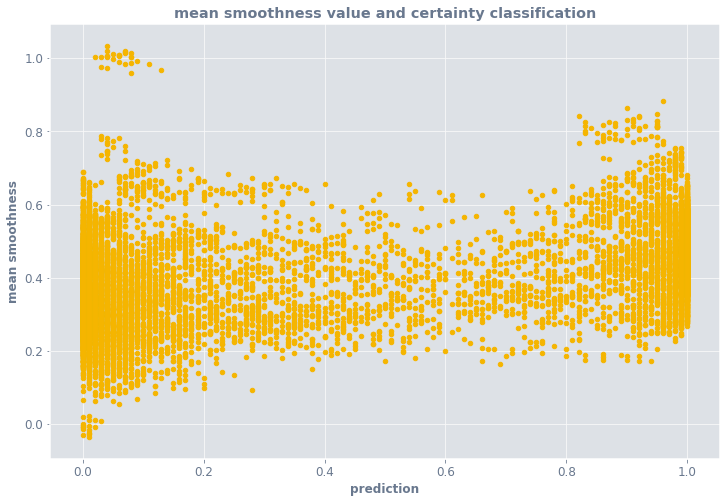

In [10]:
hd.density_scatter("mean smoothness")

Select 5 most important features to visualize.

In [11]:
features = [(f, i) for f, i in zip(hd.scaled.columns, rf_clf.feature_importances_)]   
features.sort(key=lambda x: x[1], reverse=True)
features = [i[0] for i in features[:5]]
print(features)

hd.select_vis_cols(features, n_bins=25)

['worst concave points', 'mean concave points', 'worst area', 'mean concavity', 'worst perimeter']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


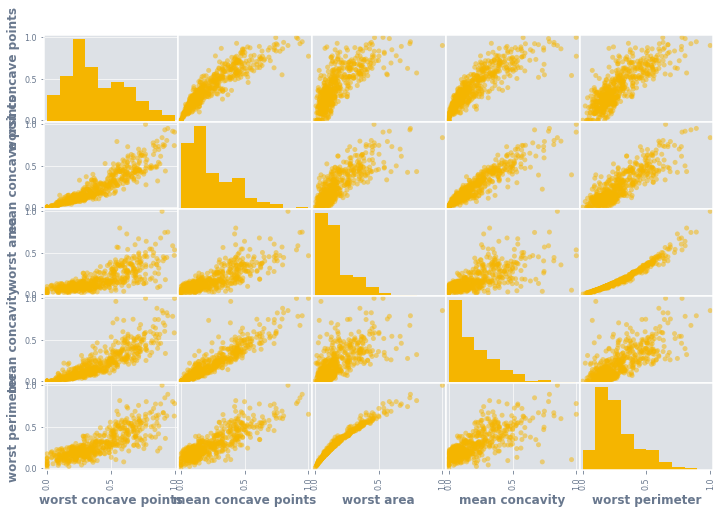

In [12]:
hd.scatter_plot_matrix(features)

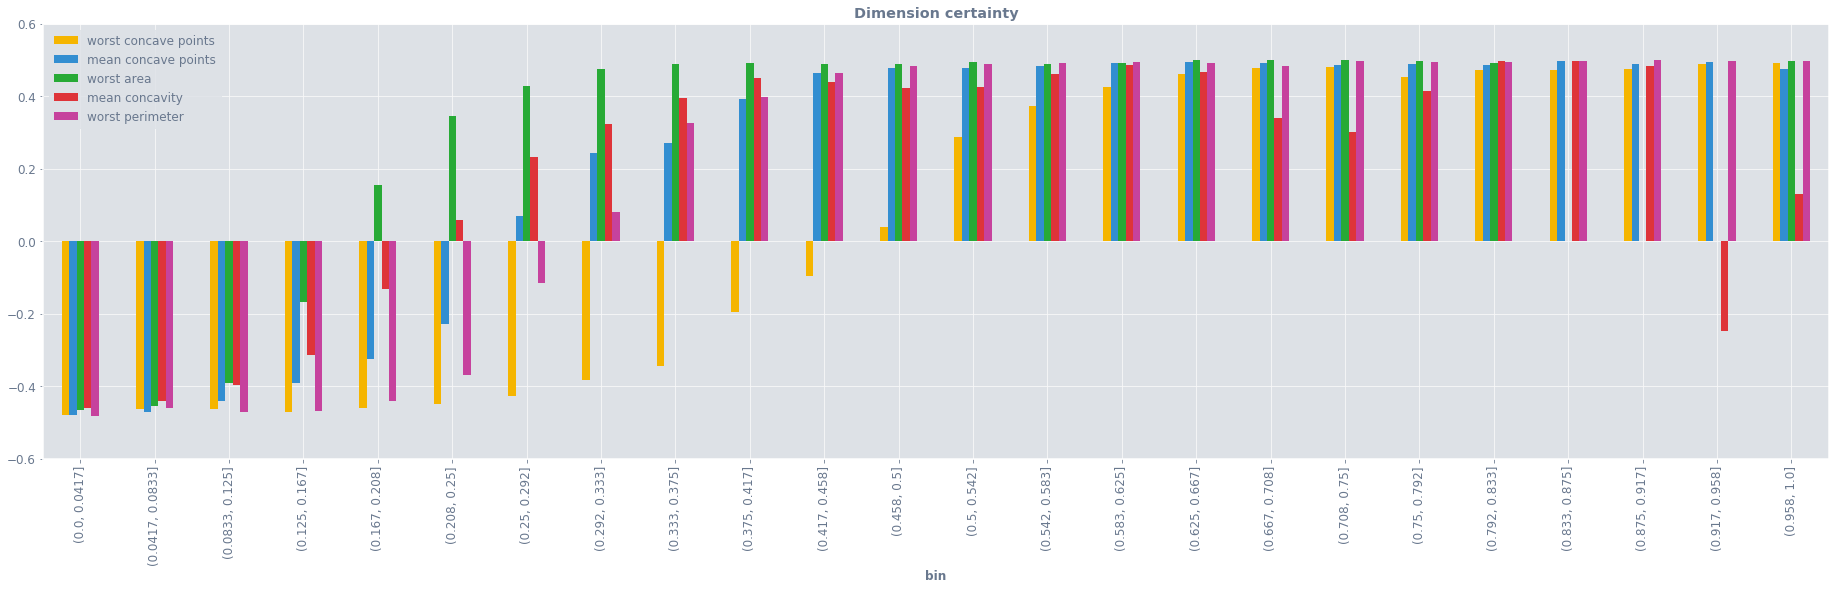

In [13]:
hd.vis_1d(figsize=(32, 8))

Everything red will be classified as malignant, everything blue will be classified as benign.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


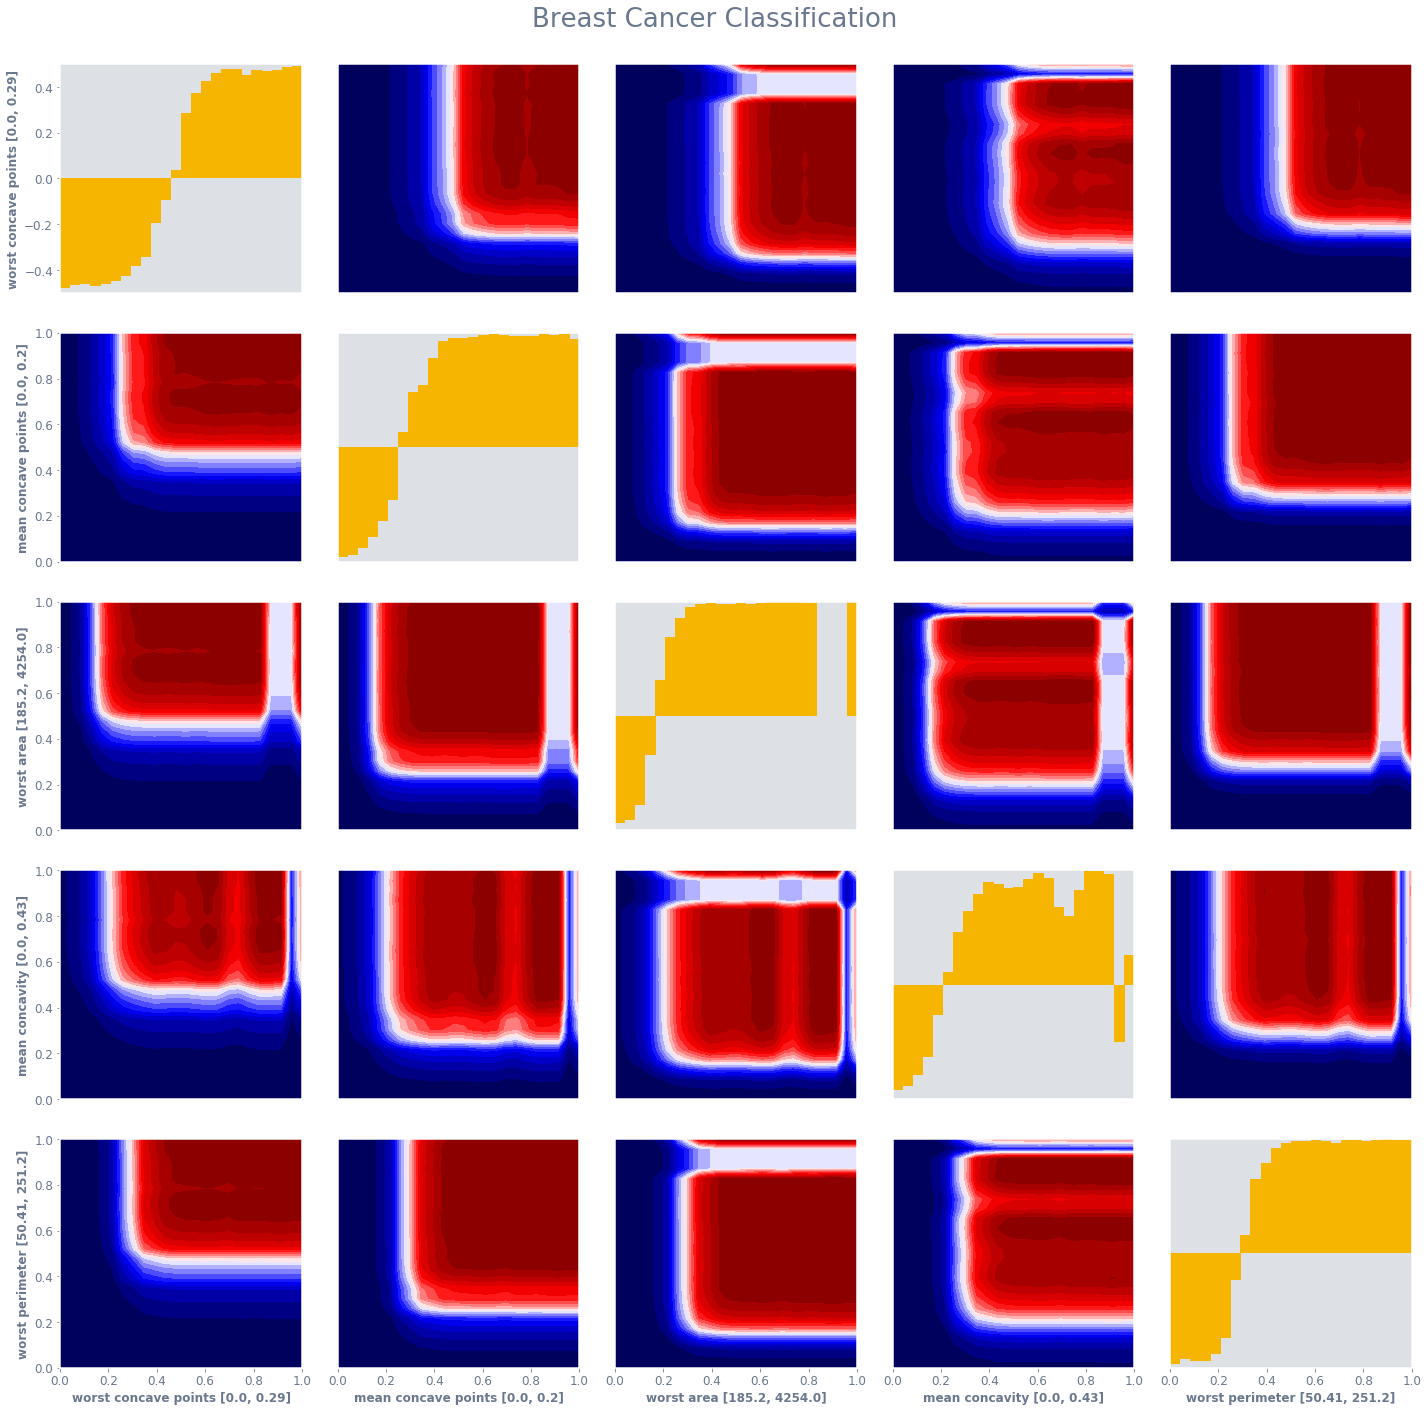

In [14]:
hd.vis_2d(title="Breast Cancer Classification")

### One Class SVM
Used for outlier detection/estimating a learning frontier. The SVM is set to use 10% of points estimated as outliers to set the learning frontier.

In [15]:
oc_clf = OneClassSVM(gamma='auto', nu=0.1).fit(hd.scaled)

In [16]:
# Certainty 
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [17]:
tst = oc_clf_func(hd.scaled)
pd.Series(tst).value_counts()

1.0    512
0.0     57
dtype: int64

In [18]:
hd.density_estimate(oc_clf_func, n=10000)

/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


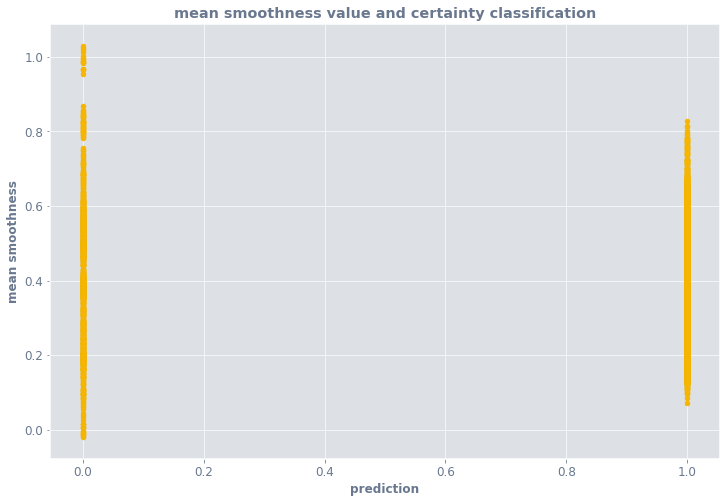

In [19]:
hd.density_scatter("mean smoothness")

In [20]:
hd.select_vis_cols(features, n_bins=25)

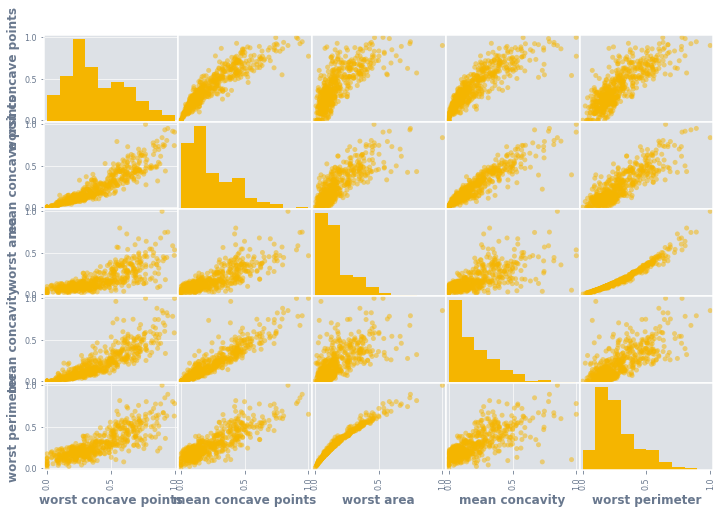

In [21]:
hd.scatter_plot_matrix(features)

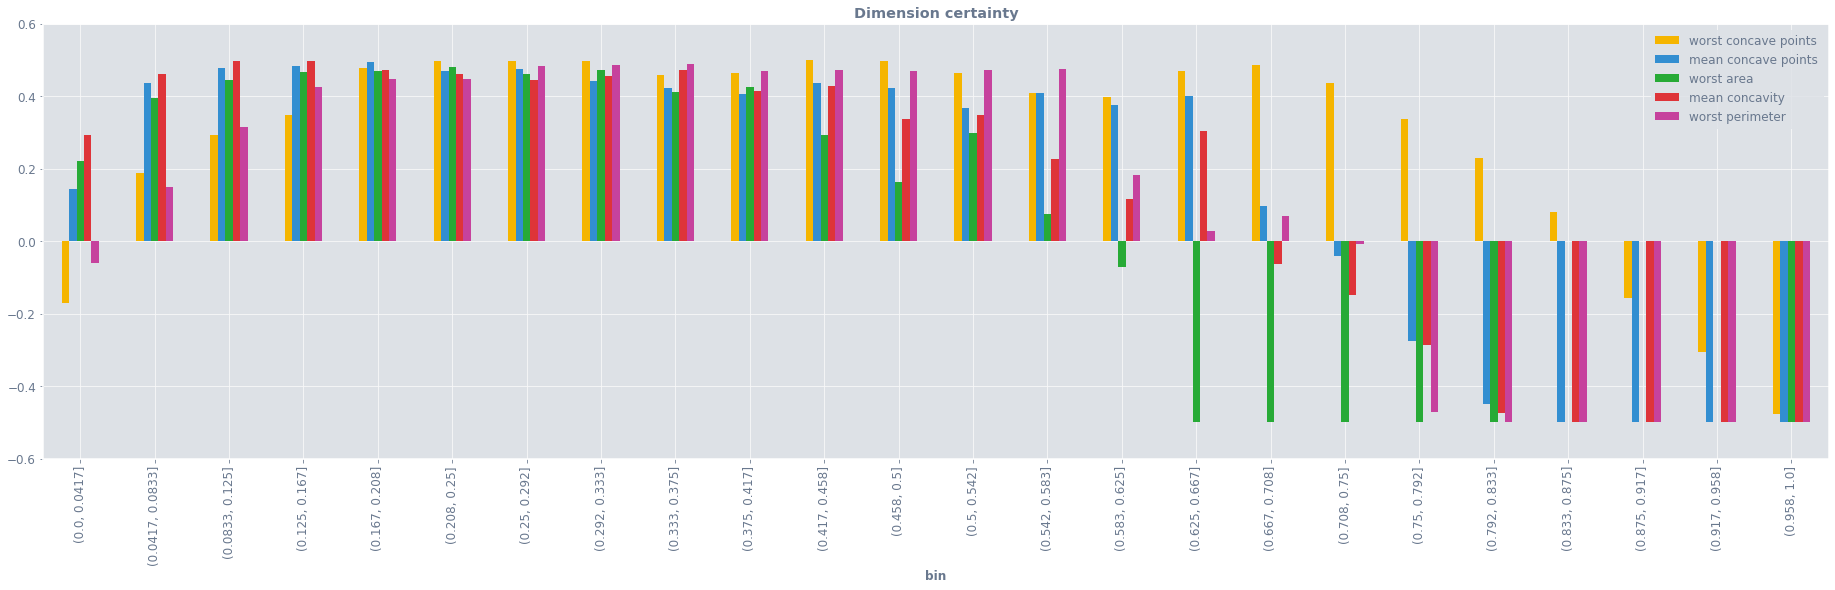

In [22]:
hd.vis_1d(figsize=(32, 8))

Red will be classified as within range of the classifier, while blue will be classified as outliers.

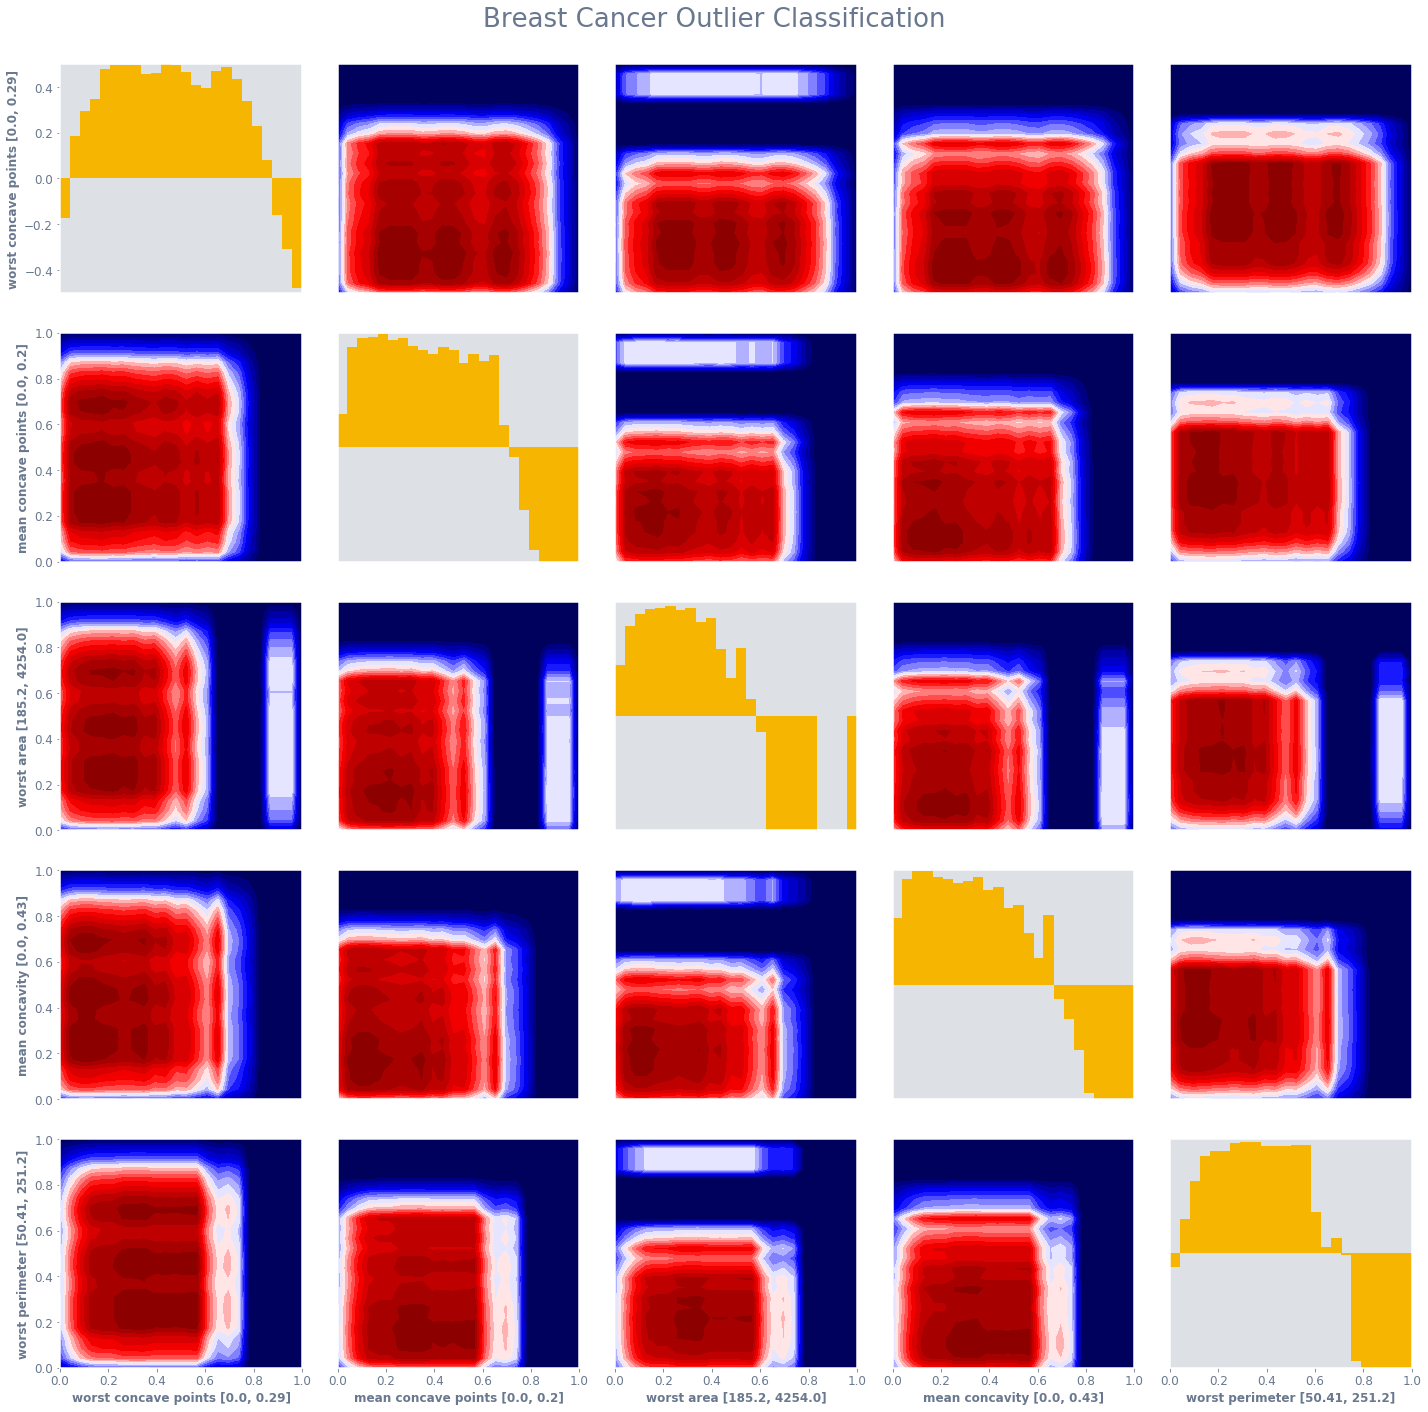

In [23]:
hd.vis_2d(title="Breast Cancer Outlier Classification")

## Random Forest Classifier and Outlier Detection Superposition

In [24]:
# Certainty 
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [25]:
tst = oc_rf_clf_func(hd.scaled)
print(tst[:30])

[0.5, 0.95, 1.0, 0.5, 1.0, 0.95, 1.0, 0.91, 0.98, 0.5, 0.56, 1.0, 0.5, 0.87, 0.93, 0.99, 0.97, 1.0, 1.0, 0.08000000000000002, 0.0, 0.010000000000000009, 0.94, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 0.89]


In [26]:
hd.density_estimate(oc_rf_clf_func, n=10000)

/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


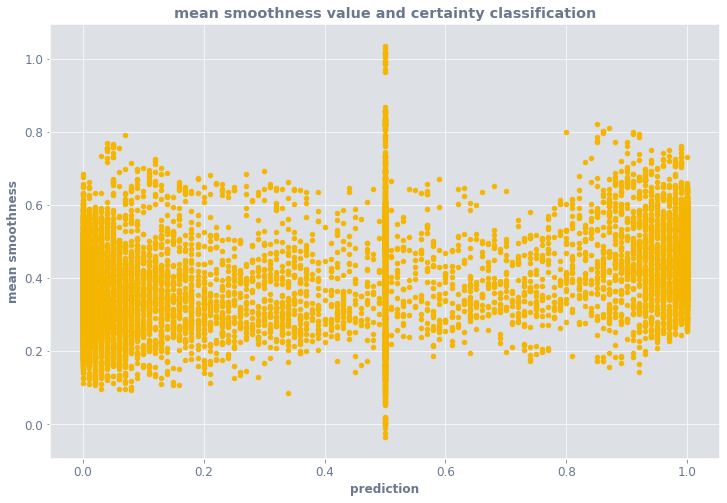

In [27]:
hd.density_scatter("mean smoothness")

In [28]:
hd.select_vis_cols(features, n_bins=25)

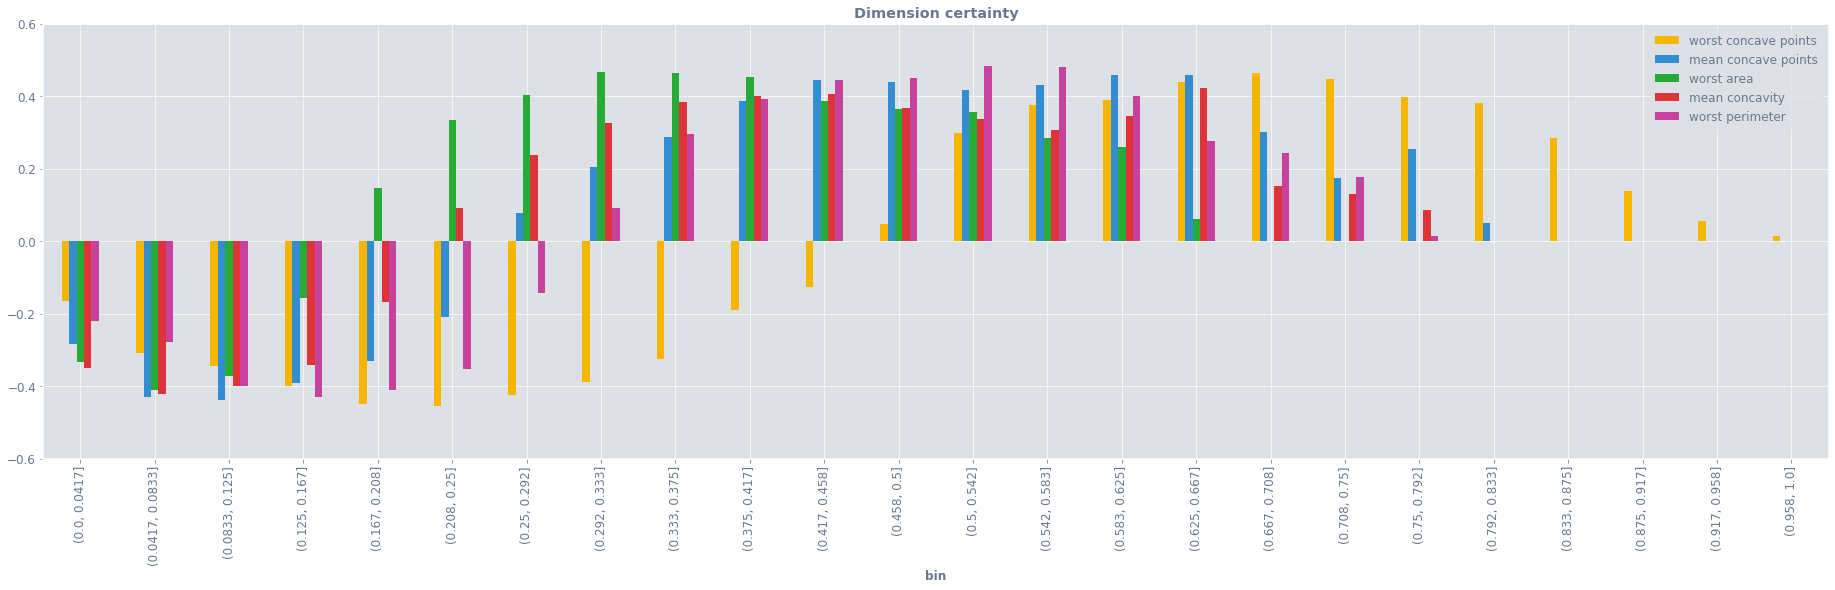

In [29]:
hd.vis_1d(figsize=(32, 8))

The areas where the classifier is uncertain have been superposed with the areas where samples are taken where training data is not present. The dark colours are strong indicates of good quality accross dimensions.

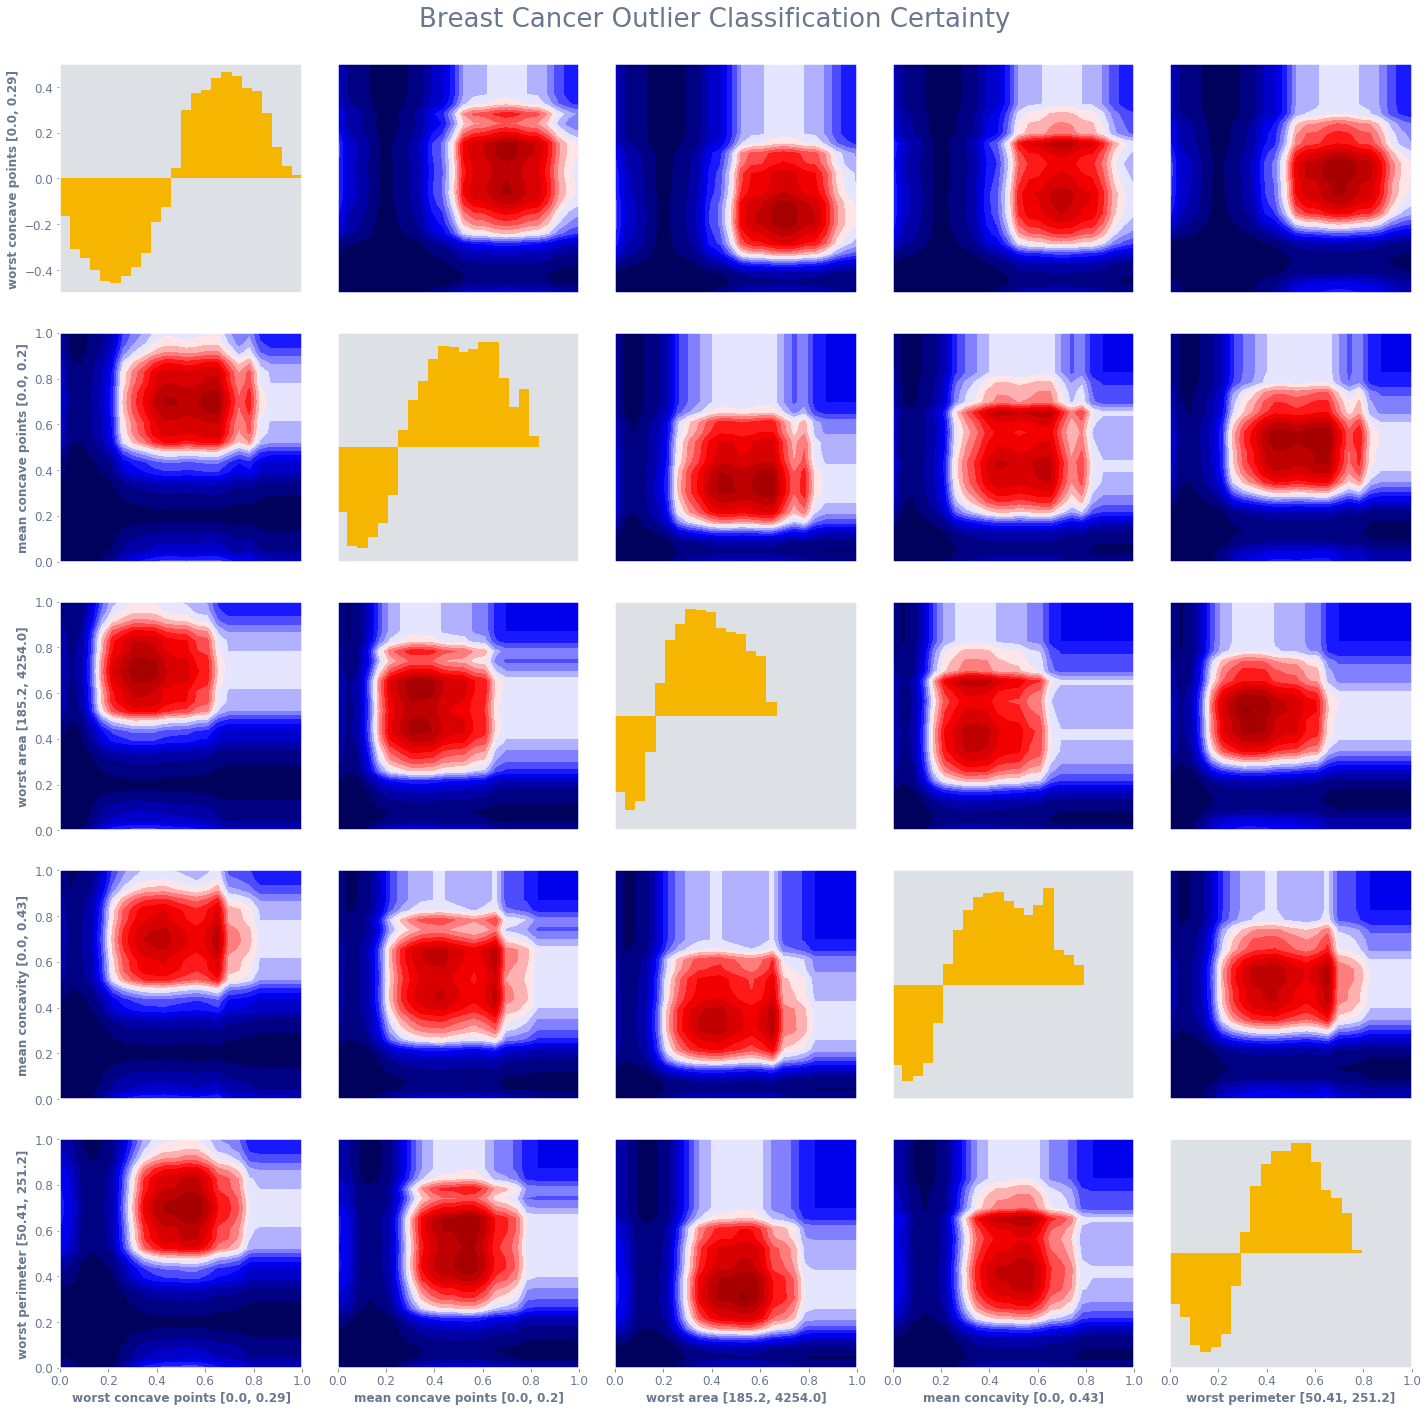

In [30]:
hd.vis_2d(title="Breast Cancer Outlier Classification Certainty")

## Neural Network

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 30 dimensions go in, 2 go out. The 2 coming out are the two
        # different classes available.
        self.fc1 = nn.Linear(hd.scaled.shape[1], 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

    def predict(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([0 if i[0] > i[1] else 1 for i in pred])
    
    def predict_proba(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([i[1] / (i[0] + i[1]) for i in pred])

In [33]:
net = Net()

# Prepare data for neural network.
inputs = torch.FloatTensor(X_train.values)
labels = torch.LongTensor([1 if i == "malignant" else 0 for i in y_train])

# Optimizer to speed things up, cross entropy loss as it is a classifcation problem.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
epochs = 10000

losses = []
for epoch in range(epochs):
    outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("epoch:", epoch, "loss:", loss)
    
print('Finished Training ')

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0 loss: tensor(0.6938, grad_fn=<NllLossBackward>)
epoch: 100 loss: tensor(0.1188, grad_fn=<NllLossBackward>)
epoch: 200 loss: tensor(0.0672, grad_fn=<NllLossBackward>)
epoch: 300 loss: tensor(0.0536, grad_fn=<NllLossBackward>)
epoch: 400 loss: tensor(0.0470, grad_fn=<NllLossBackward>)
epoch: 500 loss: tensor(0.0421, grad_fn=<NllLossBackward>)
epoch: 600 loss: tensor(0.0371, grad_fn=<NllLossBackward>)
epoch: 700 loss: tensor(0.0312, grad_fn=<NllLossBackward>)
epoch: 800 loss: tensor(0.0249, grad_fn=<NllLossBackward>)
epoch: 900 loss: tensor(0.0195, grad_fn=<NllLossBackward>)
epoch: 1000 loss: tensor(0.0154, grad_fn=<NllLossBackward>)
epoch: 1100 loss: tensor(0.0123, grad_fn=<NllLossBackward>)
epoch: 1200 loss: tensor(0.0100, grad_fn=<NllLossBackward>)
epoch: 1300 loss: tensor(0.0082, grad_fn=<NllLossBackward>)
epoch: 1400 loss: tensor(0.0068, grad_fn=<NllLossBackward>)
epoch: 1500 loss: tensor(0.0057, grad_fn=<NllLossBackward>)
epoch: 1600 loss: tensor(0.0049, grad_fn=<NllLossBac

Test NN accuracy.

In [34]:
test_input = torch.FloatTensor(X_test.values)
preds = np.array(net.predict(test_input))
test_labels = [1 if i == "malignant" else 0 for i in y_test]
print(preds)
print("F1 score:", f1_score(test_labels, preds, pos_label=1))
print("Confusion matrix:")
print(confusion_matrix(test_labels, preds))

[0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1
 1 0 0]
F1 score: 0.9481481481481482
Confusion matrix:
[[117   4]
 [  3  64]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The actual classifier function uses the raw certainty of the model.

In [35]:
preds = np.array(net.predict_proba(test_input))
for i in zip(preds, test_labels):
    print(i)

(5.087472e-06, 0)
(1.0, 1)
(1.0, 1)
(5.3599493e-16, 0)
(5.037051e-16, 0)
(1.0, 1)
(1.0, 1)
(0.999767, 1)
(1.3118473e-05, 0)
(8.039757e-10, 0)
(1.6282022e-06, 0)
(1.0, 1)
(5.511243e-09, 0)
(0.04495393, 1)
(3.477996e-11, 0)
(0.9999813, 1)
(1.1609367e-15, 0)
(9.334724e-16, 0)
(4.5156655e-16, 0)
(1.0, 1)
(5.874702e-10, 1)
(1.297184e-13, 0)
(1.0, 1)
(8.87822e-08, 0)
(1.7467394e-07, 0)
(6.185005e-16, 0)
(2.1638494e-15, 0)
(4.6004024e-07, 0)
(4.869075e-13, 0)
(1.0, 1)
(1.5711085e-07, 0)
(6.09274e-16, 0)
(5.6236768e-08, 0)
(1.1671406e-14, 0)
(1.1839792e-14, 0)
(2.016749e-11, 0)
(1.0, 1)
(0.7471711, 0)
(1.0, 1)
(1.858632e-07, 0)
(1.2084319e-11, 0)
(1.0, 1)
(2.0706358e-15, 0)
(1.1112277e-14, 0)
(0.0009390398, 0)
(0.1207214, 0)
(1.0325432e-14, 0)
(1.7458201e-07, 0)
(6.649201e-08, 0)
(2.1822436e-15, 0)
(1.0, 1)
(1.0, 1)
(0.0017782274, 0)
(0.0001514628, 0)
(4.3975857e-16, 0)
(1.4914267e-10, 0)
(9.348908e-16, 0)
(1.0, 1)
(0.99999285, 1)
(5.746571e-16, 0)
(2.4404407e-13, 0)
(1.0, 1)
(1.0, 1)
(1.40490

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [36]:
# Certainty 
def nn_clf_func(df):
    test_tensor = torch.FloatTensor(df.values)
    return np.array(net.predict_proba(test_tensor))

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


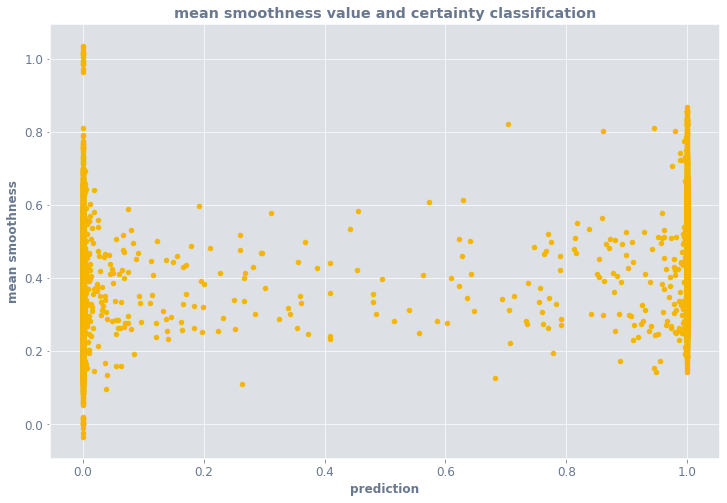

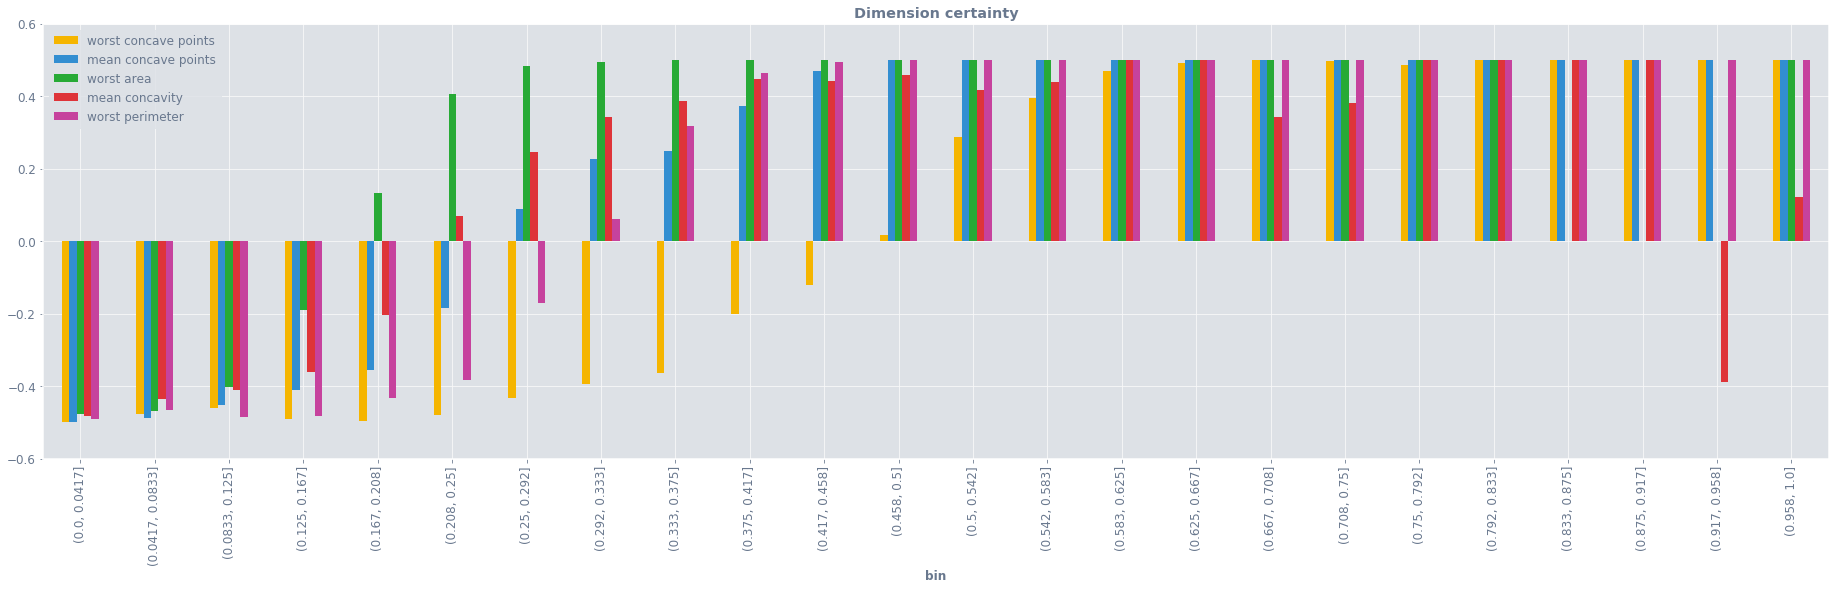

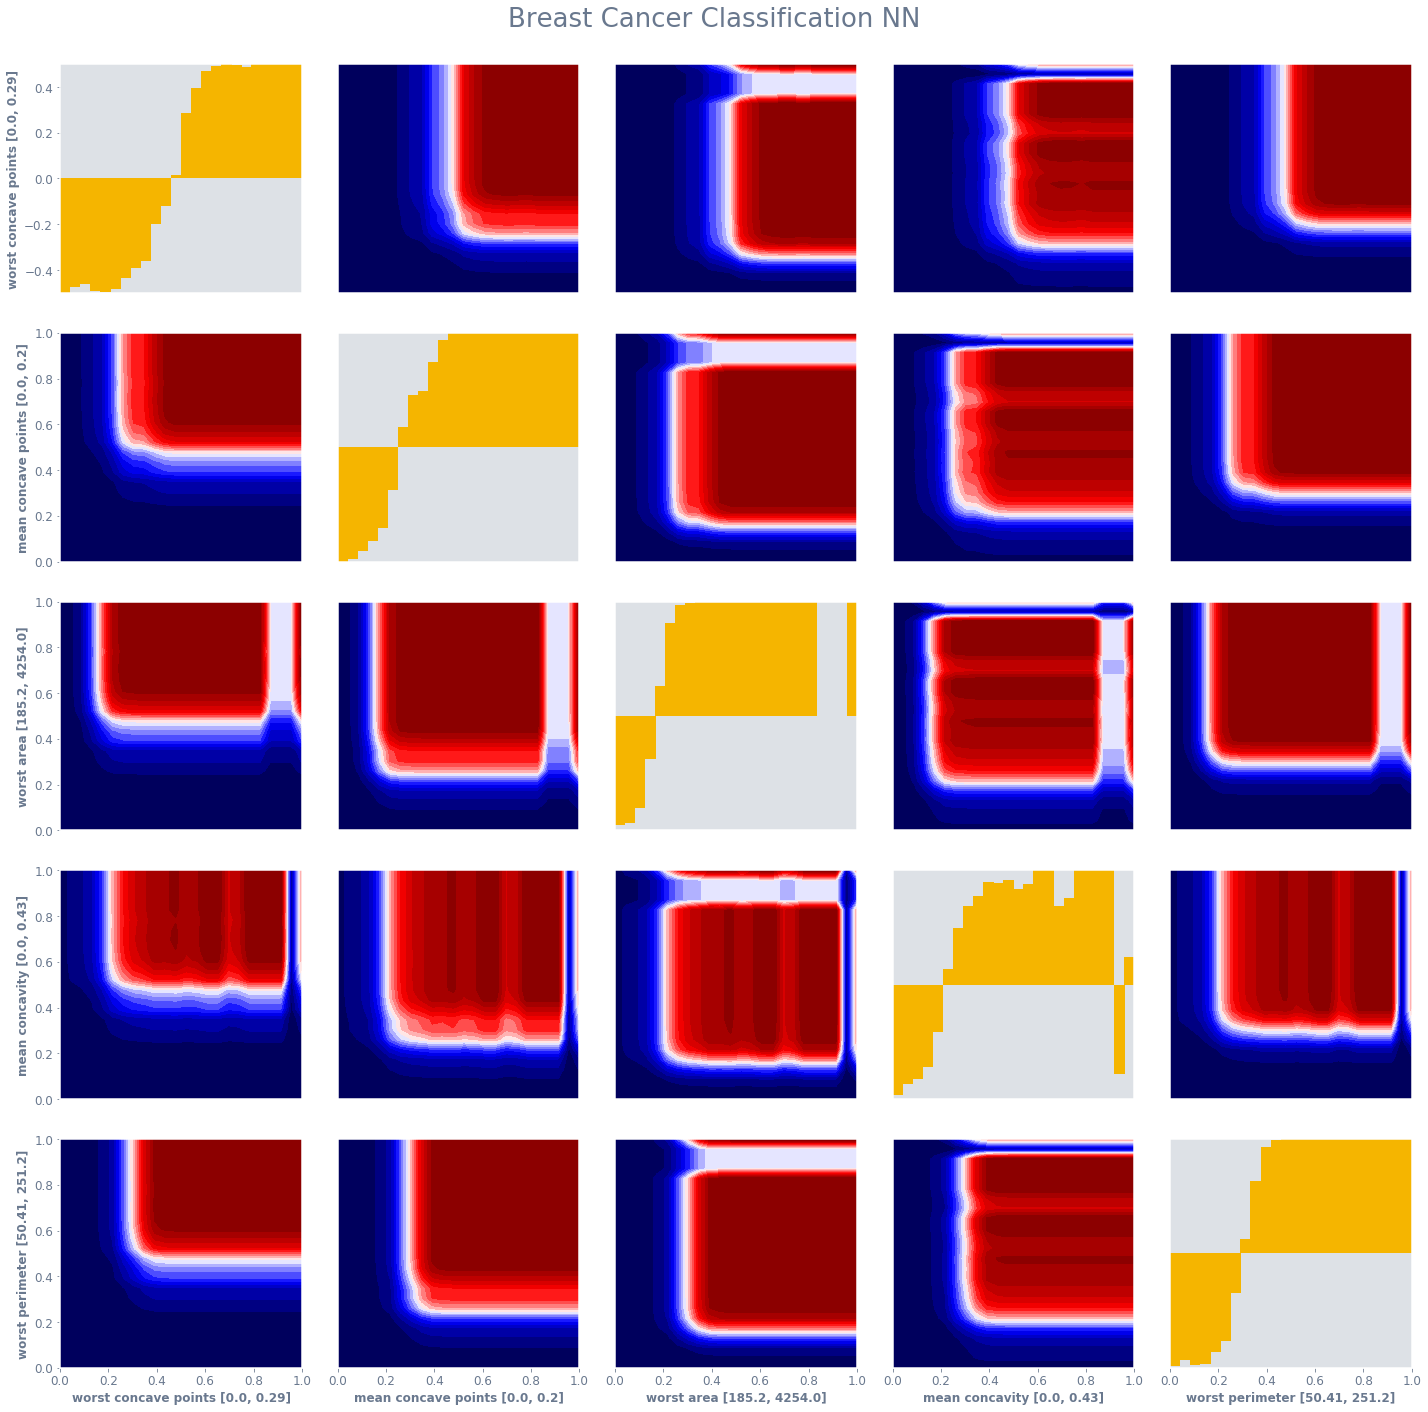

In [37]:
hd.density_estimate(nn_clf_func, n=10000)
hd.density_scatter("mean smoothness")
hd.select_vis_cols(features, n_bins=25)
hd.vis_1d(figsize=(32, 8))
hd.vis_2d(title="Breast Cancer Classification NN")

## NN Classifier and Outlier Detection Superposition

In [38]:
# Certainty 
def oc_nn_clf_func(df):
    oc_pred = oc_clf_func(df)
    nn_pred = nn_clf_func(df)
    return [(nn_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [42]:
tst = oc_nn_clf_func(hd.scaled)
print(tst[:30])

[0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.9999710321426392, 1.0, 0.5, 1.0, 1.0, 0.5, 0.9998781085014343, 0.9999955892562866, 1.0, 1.0, 1.0, 1.0, 4.32786691817455e-06, 1.887379141862766e-15, 1.7208456881689926e-15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999767005443573]


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


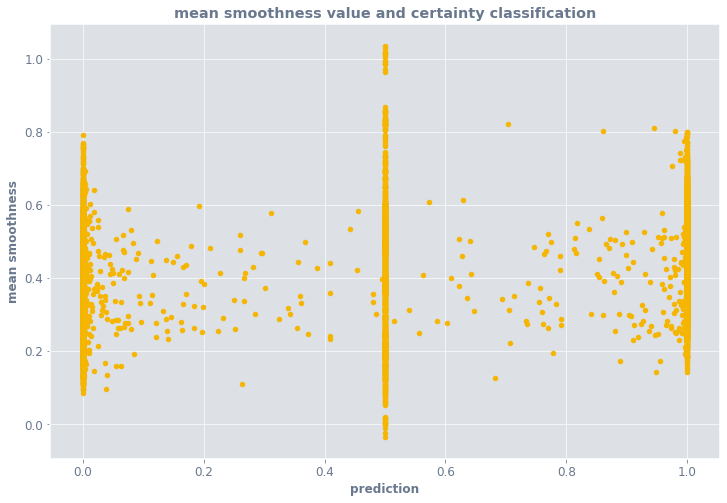

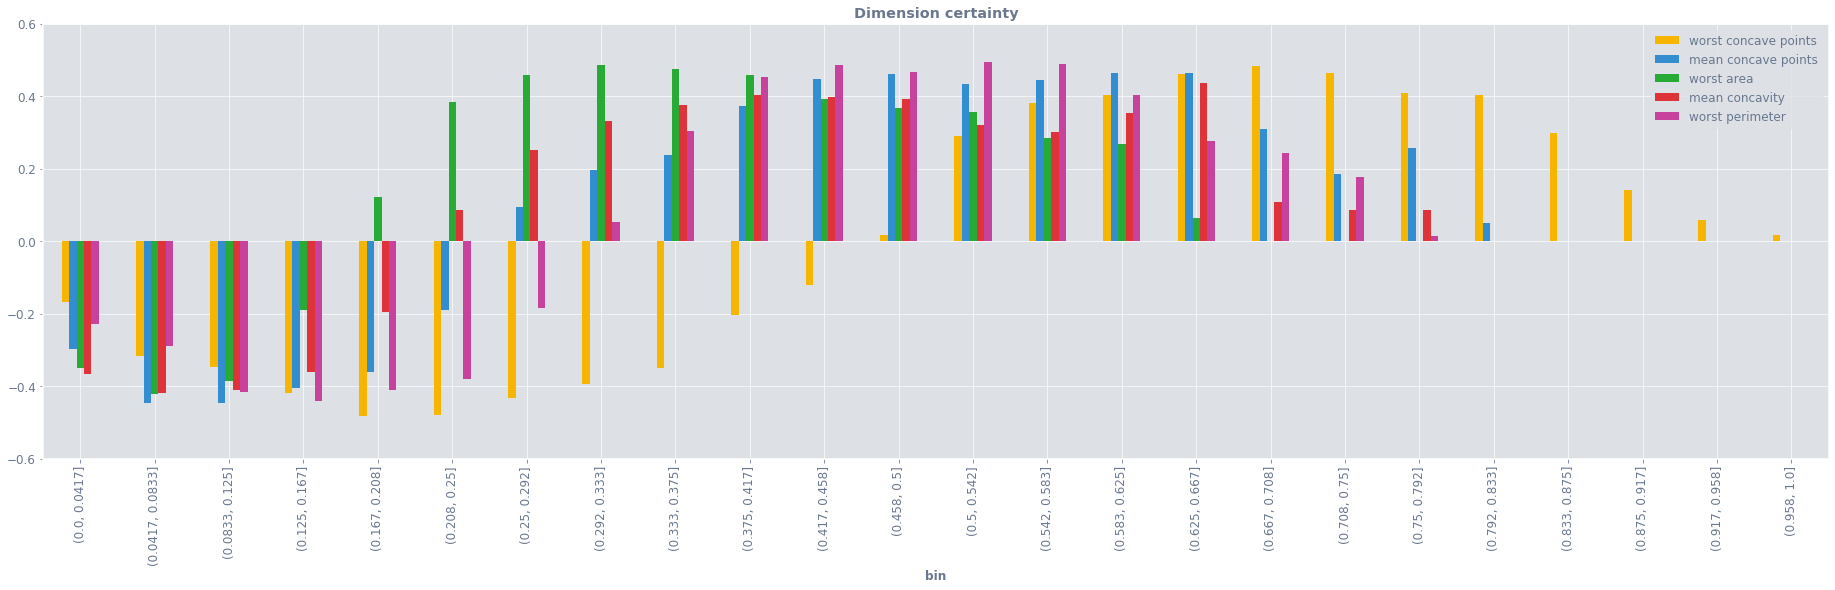

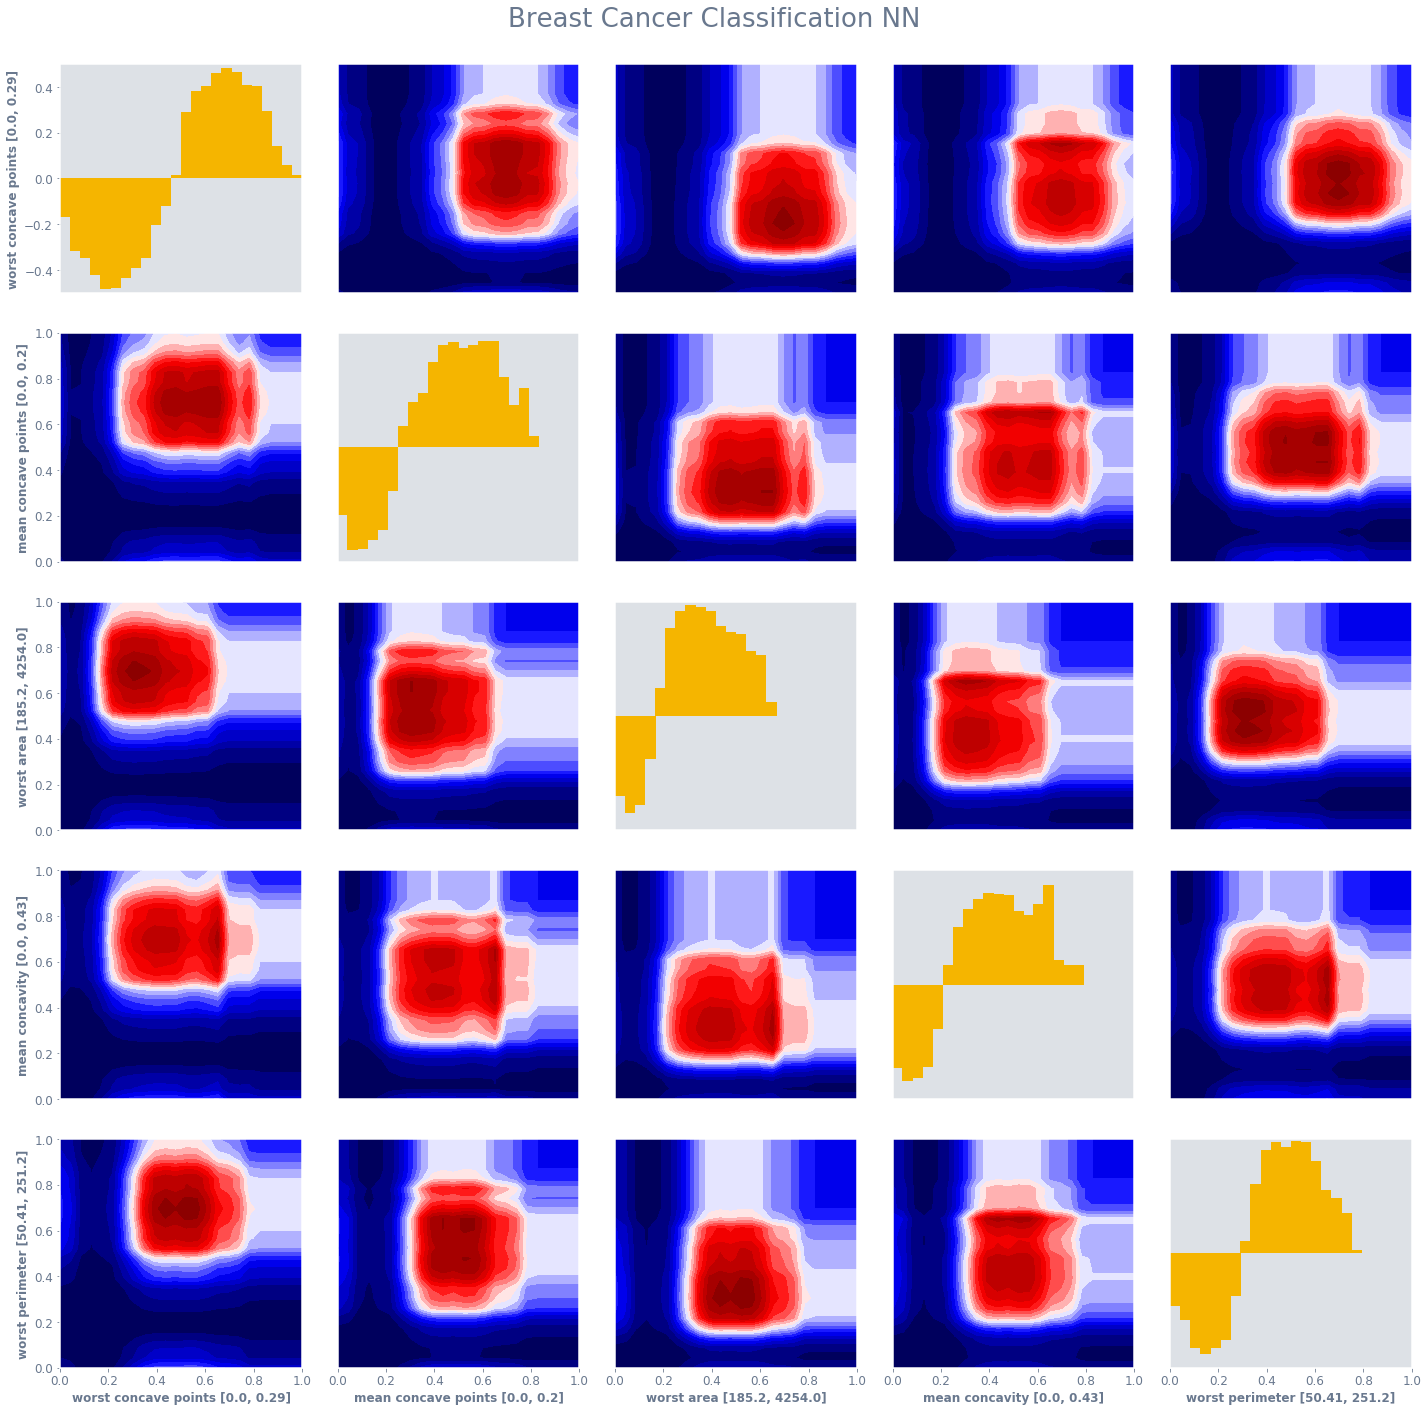

In [44]:
hd.density_estimate(oc_nn_clf_func, n=10000)
hd.density_scatter("mean smoothness")
hd.select_vis_cols(features, n_bins=25)
hd.vis_1d(figsize=(32, 8))
hd.vis_2d(title="Breast Cancer Classification NN")